# Manipulating time series data by Data Camp
## Part 4 : Putting it all together: Building a value-weighted index  
  
### Select index components & import data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal, seed
from scipy.stats import norm
import seaborn as sns

plt.rcParams['figure.figsize'] = [20, 7]

#### Explore and clean company listing information

In [2]:
import xlrd
xls = xlrd.open_workbook("./stock_data/listings.xlsx", on_demand=True)
sheet_names = xls.sheet_names()

def getDataFrame(val):
    curr_df = pd.read_excel("./stock_data/listings.xlsx", sheet_name=val)
    curr_df["Exchange"] = val
    return curr_df

df_listings_list = [ getDataFrame(i) for i in (sheet_names)]
listings = pd.concat(df_listings_list)

listings = listings[['Exchange', 'Stock Symbol', 'Company Name', 'Last Sale', 'Market Capitalization', 'IPO Year', 'Sector', 'Industry']]

In [3]:
# Inspect listings
print(listings.info())

# Move 'stock symbol' into the index
listings.set_index('Stock Symbol', inplace=True)

# Drop rows with missing 'sector' data
listings.dropna(subset=['Sector'], inplace=True)

# Select companies with IPO Year before 2019
listings = listings[listings["IPO Year"] <= 2019]

# Inspect the new listings data
print(listings.info())

# Show the number of companies per sector
print(listings.groupby(['Sector']).size().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6674 entries, 0 to 3146
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exchange               6674 non-null   object 
 1   Stock Symbol           6674 non-null   object 
 2   Company Name           6674 non-null   object 
 3   Last Sale              6590 non-null   float64
 4   Market Capitalization  6674 non-null   float64
 5   IPO Year               2852 non-null   float64
 6   Sector                 5182 non-null   object 
 7   Industry               5182 non-null   object 
dtypes: float64(3), object(5)
memory usage: 469.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exchange               2349 non-null   object 
 1   Company Name           2349 non-null   object 
 2   

### Select and inspect index components

In [4]:
df_listings_list = [ getDataFrame(i) for i in (sheet_names)]
listings = pd.concat(df_listings_list)

listings = listings[['Exchange', 'Stock Symbol', 'Company Name', 'Last Sale', 'Market Capitalization', 'IPO Year', 'Sector', 'Industry']]
listings = listings.set_index("Stock Symbol")

In [5]:
print(listings.info())
# Select largest company for each sector
components = listings.groupby(['Sector'])['Market Capitalization'].nlargest(1)

# Print components, sorted by market cap
print(components.sort_values(ascending=False))

# Select stock symbols and print the result
tickers = components.index.get_level_values('Stock Symbol')
print(tickers)

# Print company name, market cap, and last price for each component 
info_cols = ["Company Name", "Market Capitalization", "Last Sale"]
print(listings.loc[tickers, info_cols].sort_values("Market Capitalization", ascending=False))

<class 'pandas.core.frame.DataFrame'>
Index: 6674 entries, XXII to ZTO
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exchange               6674 non-null   object 
 1   Company Name           6674 non-null   object 
 2   Last Sale              6590 non-null   float64
 3   Market Capitalization  6674 non-null   float64
 4   IPO Year               2852 non-null   float64
 5   Sector                 5182 non-null   object 
 6   Industry               5182 non-null   object 
dtypes: float64(3), object(4)
memory usage: 417.1+ KB
None
Sector                 Stock Symbol
Technology             AAPL            7.400245e+11
Consumer Services      AMZN            4.221385e+11
Health Care            JNJ             3.388344e+11
Energy                 XOM             3.387287e+11
Finance                JPM             3.002833e+11
Miscellaneous          BABA            2.755250e+11
Public Utilities      

#### Import index component price information

['RIO', 'ILMN', 'CPRT', 'EL', 'AMZN', 'PAA', 'GS', 'AMGN', 'MA', 'TEF', 'AAPL', 'UPS']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1761 non-null   float64
 5   GS      1761 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1761 non-null   float64
 8   PAA     1761 non-null   float64
 9   RIO     1761 non-null   float64
 10  TEF     1761 non-null   float64
 11  UPS     1761 non-null   float64
dtypes: float64(12)
memory usage: 178.9 KB
None


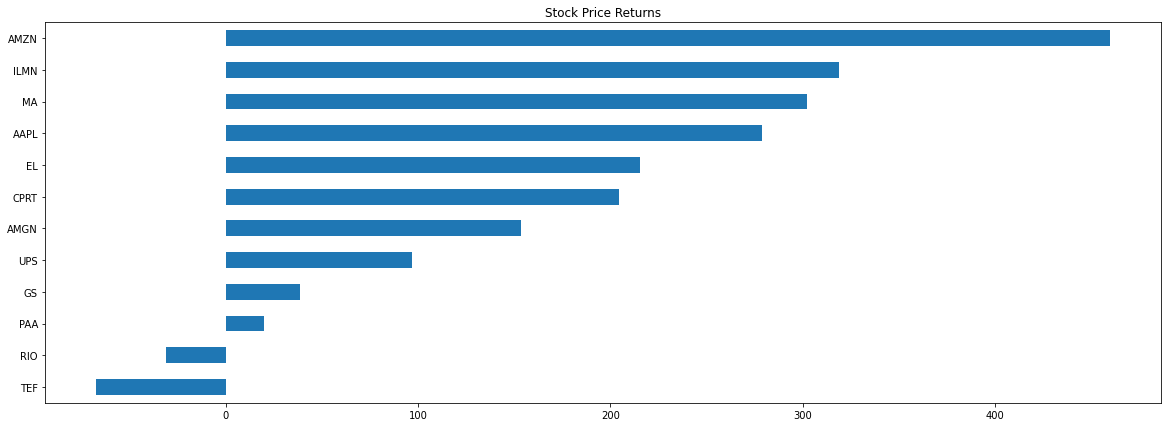

In [6]:
tickers = ['RIO', 'ILMN', 'CPRT', 'EL', 'AMZN', 'PAA', 'GS', 'AMGN', 'MA', 'TEF', 'AAPL', 'UPS']

# Print tickers
print(tickers)

# Import prices and inspect result
stock_prices = pd.read_csv("./stock_data/stock_data.csv", parse_dates=["Date"], index_col=["Date"]).dropna()
print(stock_prices.info())

# Calculate the returns
price_return = stock_prices.iloc[-1].div(stock_prices.iloc[0]).sub(1).mul(100)

# Plot horizontal bar chart of sorted price_return   
price_return.sort_values().plot(kind='barh', title='Stock Price Returns')
plt.show()


## Build your value-weighted index

#### Calculate number of shares outstanding

In [7]:
df_listings_list = [ getDataFrame(i) for i in (sheet_names)]
listings = pd.concat(df_listings_list)

listings = listings[['Exchange', 'Stock Symbol', 'Company Name', 'Last Sale', 'Market Capitalization', 'IPO Year', 'Sector', 'Industry']]
listings = listings.set_index("Stock Symbol")

tickers = ['RIO', 'ILMN', 'CPRT', 'EL', 'AMZN', 'PAA', 'GS', 'AMGN', 'MA', 'TEF', 'AAPL', 'UPS']

# Inspect listings and print tickers
print(listings.info())
print(tickers)

# Select components and relevant columns from listings
components = listings.loc[tickers, ["Market Capitalization", 'Last Sale']]

# Print the first rows of components
print(components.head())

# Calculate the number of shares here
no_shares = components["Market Capitalization"].div(components['Last Sale'])

# Print the sorted no_shares
print(no_shares.sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
Index: 6674 entries, XXII to ZTO
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exchange               6674 non-null   object 
 1   Company Name           6674 non-null   object 
 2   Last Sale              6590 non-null   float64
 3   Market Capitalization  6674 non-null   float64
 4   IPO Year               2852 non-null   float64
 5   Sector                 5182 non-null   object 
 6   Industry               5182 non-null   object 
dtypes: float64(3), object(4)
memory usage: 417.1+ KB
None
['RIO', 'ILMN', 'CPRT', 'EL', 'AMZN', 'PAA', 'GS', 'AMGN', 'MA', 'TEF', 'AAPL', 'UPS']
              Market Capitalization  Last Sale
Stock Symbol                                  
RIO                    7.043148e+10      38.94
ILMN                   2.540938e+10     173.68
CPRT                   1.362092e+10      29.65
EL                     3.112251e+10      84.94
A

### Create time series of market value

In [8]:
df_listings_list = [ getDataFrame(i) for i in (sheet_names)]
listings = pd.concat(df_listings_list)

listings = listings[['Exchange', 'Stock Symbol', 'Company Name', 'Last Sale', 'Market Capitalization', 'IPO Year', 'Sector', 'Industry']]
listings = listings.set_index("Stock Symbol")

tickers = ['RIO', 'ILMN', 'CPRT', 'EL', 'AMZN', 'PAA', 'GS', 'AMGN', 'MA', 'TEF', 'AAPL', 'UPS']

# Inspect listings and print tickers
print(listings.info())
print(tickers)

# Select components and relevant columns from listings
components = listings.loc[tickers, ["Market Capitalization", 'Last Sale']]
components['Number of Shares'] = components["Market Capitalization"].div(components['Last Sale'])

stock_prices = pd.read_csv("./stock_data/stock_data.csv", parse_dates=["Date"], index_col=["Date"]).dropna()

<class 'pandas.core.frame.DataFrame'>
Index: 6674 entries, XXII to ZTO
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exchange               6674 non-null   object 
 1   Company Name           6674 non-null   object 
 2   Last Sale              6590 non-null   float64
 3   Market Capitalization  6674 non-null   float64
 4   IPO Year               2852 non-null   float64
 5   Sector                 5182 non-null   object 
 6   Industry               5182 non-null   object 
dtypes: float64(3), object(4)
memory usage: 417.1+ KB
None
['RIO', 'ILMN', 'CPRT', 'EL', 'AMZN', 'PAA', 'GS', 'AMGN', 'MA', 'TEF', 'AAPL', 'UPS']


Stock Symbol
ILMN    1.463000e+08
EL      3.664058e+08
GS      3.978174e+08
CPRT    4.593903e+08
AMZN    4.771706e+08
PAA     7.234050e+08
AMGN    7.358902e+08
UPS     8.692972e+08
MA      1.108884e+09
RIO     1.808718e+09
TEF     5.037805e+09
AAPL    5.246540e+09
Name: Number of Shares, dtype: float64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1761 non-null   float64
 5   GS      1761 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1761 non-null   float64
 8   PAA     1761 non-null   float64
 9   RIO     1761 non-null   float64
 10  TEF     1761 non-null   float64
 11  UPS     1761 non-null   float64
dtypes: float64(12)
memory usage: 178.9 KB
None


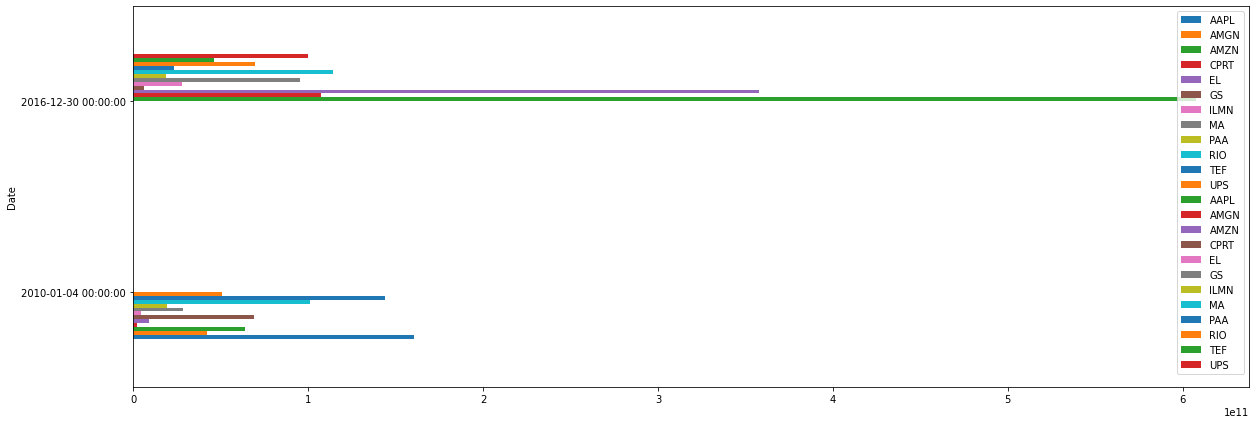

In [9]:
# Select the number of shares
no_shares = components['Number of Shares']
print(no_shares.sort_values(ascending=True))

print(stock_prices.info())

# Create the series of market cap per ticker
market_cap = stock_prices.mul(no_shares, axis=1)

# Select first and last market cap here
first_value = market_cap.first("D")
last_value = market_cap.last("D")


# Concatenate and plot first and last market cap here
pd.concat([first_value, last_value], axis=1).plot(kind='barh')
plt.show()


#### Calculate & plot the composite index

In [10]:
df_listings_list = [ getDataFrame(i) for i in (sheet_names)]
listings = pd.concat(df_listings_list)

listings = listings[['Exchange', 'Stock Symbol', 'Company Name', 'Last Sale', 'Market Capitalization', 'IPO Year', 'Sector', 'Industry']]
listings = listings.set_index("Stock Symbol")

tickers = ['RIO', 'ILMN', 'CPRT', 'EL', 'AMZN', 'PAA', 'GS', 'AMGN', 'MA', 'TEF', 'AAPL', 'UPS']

# Select components and relevant columns from listings
components = listings.loc[tickers, ["Market Capitalization", 'Last Sale']]
components['Number of Shares'] = components["Market Capitalization"].div(components['Last Sale'])

stock_prices = pd.read_csv("./stock_data/stock_data.csv", parse_dates=["Date"], index_col=["Date"]).dropna()

# Select the number of shares
no_shares = components['Number of Shares']

# Create the series of market cap per ticker
market_cap_series = stock_prices.mul(no_shares, axis=1)




Date
2010-01-04    6.948176e+11
2010-01-05    6.979957e+11
2010-01-06    6.946857e+11
2010-01-07    6.912416e+11
2010-01-08    6.958476e+11
                  ...     
2016-12-23    1.588874e+12
2016-12-27    1.599280e+12
2016-12-28    1.593635e+12
2016-12-29    1.589422e+12
2016-12-30    1.574862e+12
Length: 1761, dtype: float64
Date
2010-01-04    100.000000
2010-01-05    100.457394
2010-01-06     99.981005
2010-01-07     99.485328
2010-01-08    100.148231
                 ...    
2016-12-23    228.675001
2016-12-27    230.172669
2016-12-28    229.360223
2016-12-29    228.753821
2016-12-30    226.658267
Length: 1761, dtype: float64


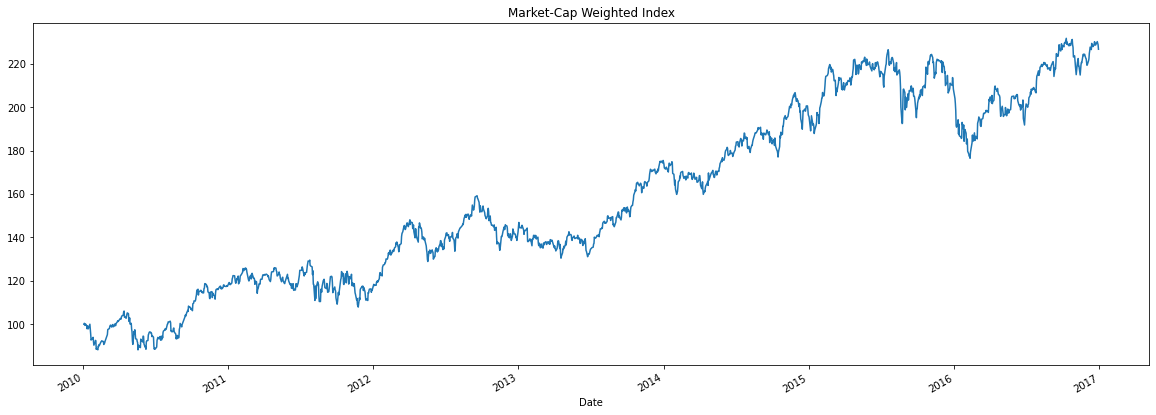

In [11]:
# Aggregate and print the market cap per trading day
raw_index = market_cap_series.sum(axis=1)
print(raw_index)

# Normalize the aggregate market cap here 
index = raw_index.div(raw_index.first("D").values[0]).mul(100)
print(index)

# Plot the index here

index.plot(title='Market-Cap Weighted Index')
plt.show()

### Evaluate index performance

#### Calculate the contribution of each stock to the index

In [12]:
df_listings_list = [ getDataFrame(i) for i in (sheet_names)]
listings = pd.concat(df_listings_list)

listings = listings[['Exchange', 'Stock Symbol', 'Company Name', 'Last Sale', 'Market Capitalization', 'IPO Year', 'Sector', 'Industry']]
listings = listings.set_index("Stock Symbol")

tickers = ['RIO', 'ILMN', 'CPRT', 'EL', 'AMZN', 'PAA', 'GS', 'AMGN', 'MA', 'TEF', 'AAPL', 'UPS']

# Select components and relevant columns from listings
components = listings.loc[tickers, ["Market Capitalization", 'Last Sale']]
components['Number of Shares'] = components["Market Capitalization"].div(components['Last Sale'])

stock_prices = pd.read_csv("./stock_data/stock_data.csv", parse_dates=["Date"], index_col=["Date"]).dropna()

# Select the number of shares
no_shares = components['Number of Shares']

# Create the series of market cap per ticker
market_cap_series = stock_prices.mul(no_shares, axis=1)


# Aggregate and print the market cap per trading day
raw_index = market_cap_series.sum(axis=1)

# Normalize the aggregate market cap here 
index = raw_index.div(raw_index.first("D").values[0]).mul(100)

126.65826661173827
Stock Symbol
CPRT    0.007564
PAA     0.012340
ILMN    0.014110
EL      0.017282
TEF     0.030324
RIO     0.039110
GS      0.049332
UPS     0.050077
AMGN    0.066039
MA      0.068484
AMZN    0.234410
AAPL    0.410929
Name: Market Capitalization, dtype: float64


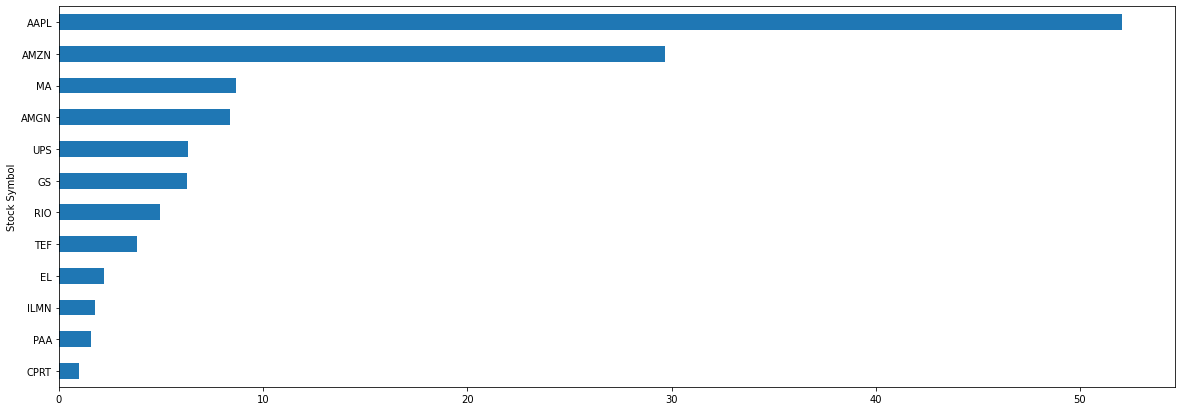

In [13]:
# Calculate and print the index return here
index_return =  (index.iloc[-1] / index.iloc[0] - 1) * 100
print(index_return)

# Select the market capitalization
market_cap = components['Market Capitalization']

# Calculate the total market cap
total_market_cap = market_cap.sum()

# Calculate the component weights, and print the result
weights = market_cap.div(total_market_cap)
print(weights.sort_values())

# Calculate and plot the contribution by component

weights.mul(index_return).sort_values().plot(kind='barh')
plt.show()

### Compare index performance against benchmark I

In [14]:
# Import and inspect djia here
djia = pd.read_csv("./stock_data/djia.csv", parse_dates=["date"], index_col=["date"])
index = pd.read_csv("./stock_data/index.csv", parse_dates=["Date"], index_col=["Date"])['Unnamed: 1']

                 Index       DJIA
Date                             
2016-12-30  126.658267  86.722172


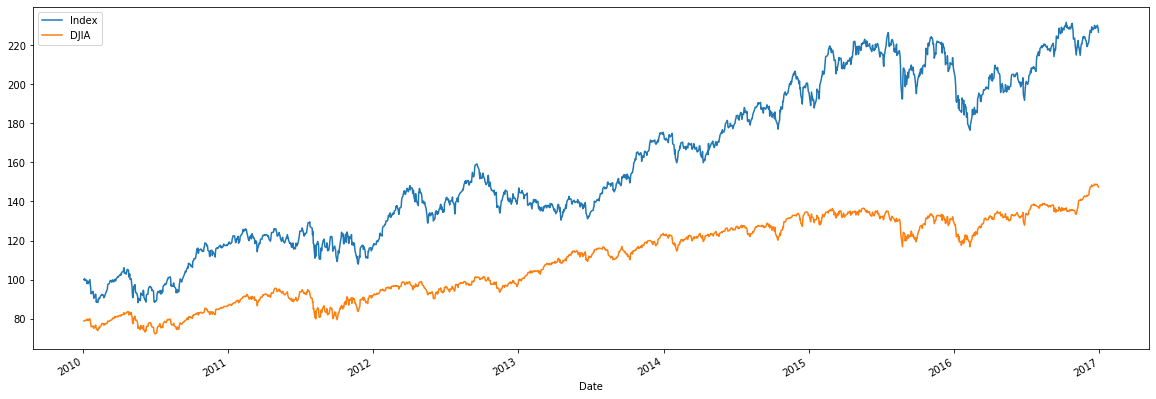

In [15]:
# Convert index series to dataframe here
data = index.to_frame(name="Index")

# Normalize djia series and add as new column to data
djia = djia.div(djia.first("D").values[0]).mul(100)
data['DJIA'] = djia

# Show total return for both index and djia
print(data.last("D").div(data.first("D").values).sub(1).mul(100))

# Plot both series

data.plot()
plt.show()

#### Compare index performance against benchmark II

In [16]:
# Import and inspect djia here
djia = pd.read_csv("./stock_data/djia2.csv", parse_dates=["DATE"], index_col=["DATE"])
index = pd.read_csv("./stock_data/index.csv", parse_dates=["Date"], index_col=["Date"])['Unnamed: 1']
# Convert index series to dataframe here
data = index.to_frame(name="Index")

# Normalize djia series and add as new column to data
djia = djia.div(djia.first("D").values[0]).mul(100)
data['DJIA'] = djia

                 Index        DJIA
Date                              
2010-01-04  100.000000  100.000000
2010-01-05  100.457394   99.887188
2010-01-06   99.981005   99.902872
2010-01-07   99.485328  100.216365
2010-01-08  100.148231  100.323414
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   1761 non-null   float64
 1   DJIA    1761 non-null   float64
dtypes: float64(2)
memory usage: 41.3 KB
None


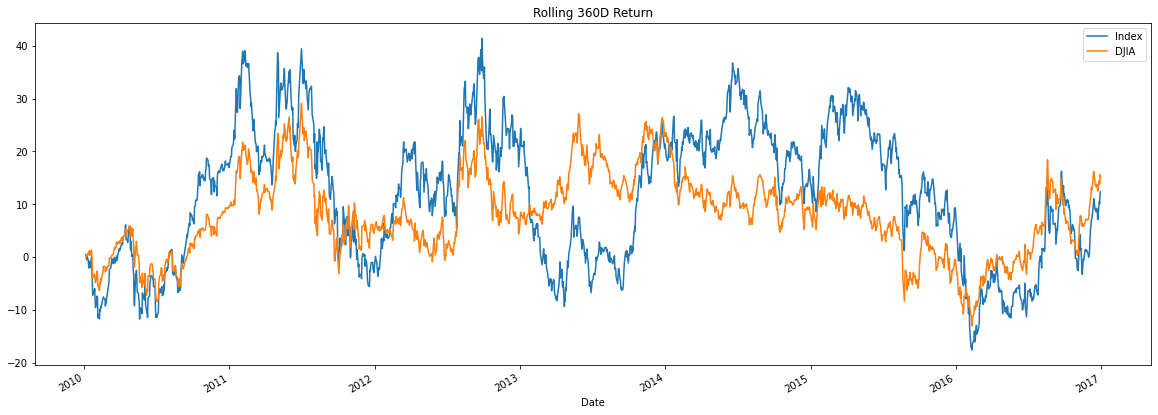

In [17]:
# Inspect data
print(data.head())
print(data.info())

# Create multi_period_return function here
def multi_period_return(r):
    return (np.prod(r + 1 ) - 1) * 100

# Calculate rolling_return_360
rolling_return_360 = data.pct_change().rolling('360D').apply(multi_period_return)

# Plot rolling_return_360 here
rolling_return_360.plot(title='Rolling 360D Return')
plt.show()

### Index correlation & exporting to Excel

In [18]:
# Import prices and inspect result
stock_prices = pd.read_csv("./stock_data/stock_data.csv", parse_dates=["Date"], index_col=["Date"]).dropna()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1761 non-null   float64
 5   GS      1761 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1761 non-null   float64
 8   PAA     1761 non-null   float64
 9   RIO     1761 non-null   float64
 10  TEF     1761 non-null   float64
 11  UPS     1761 non-null   float64
dtypes: float64(12)
memory usage: 178.9 KB
None
          AAPL      AMGN      AMZN      CPRT        EL        GS      ILMN  \
AAPL  1.000000  0.286897  0.327609  0.346615  0.307203  0.344936  0.264790   
AMGN  0.286897  1.000000  0.323407  0.355891  0.350240  0.390056  0.336926   
AMZN  0.327609  0.323407  1.000000  0.298928  0.333545  0.333555  0.242725 

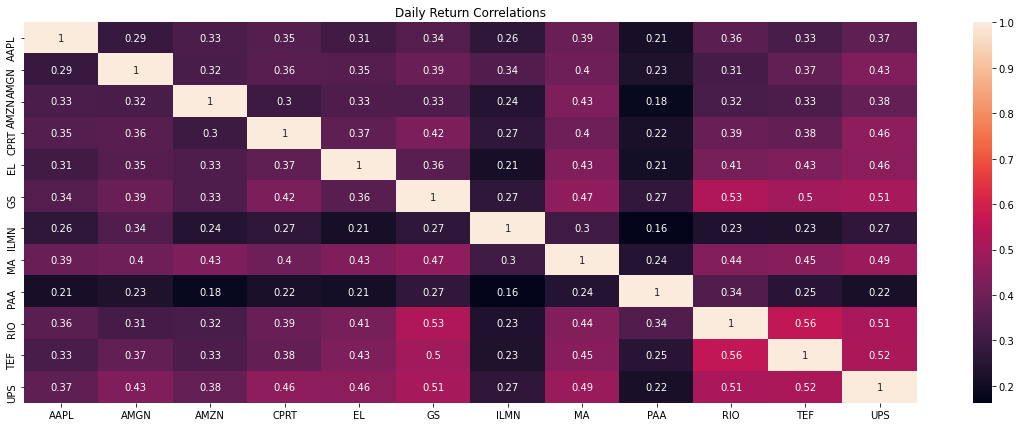

In [19]:
# Inspect stock_prices here
print(stock_prices.info())

# Calculate the daily returns
returns = stock_prices.pct_change()

# Calculate and print the pairwise correlations
correlations = returns.corr()
print(correlations)

# Plot a heatmap of daily return correlations
sns.heatmap(correlations, annot=True)
plt.title('Daily Return Correlations')
plt.show()

### Save your analysis to multiple excel worksheets



In [20]:
# Import prices and inspect result
stock_prices = pd.read_csv("./stock_data/stock_data.csv", parse_dates=["Date"], index_col=["Date"]).dropna()
index = pd.read_csv("./stock_data/index.csv", parse_dates=["Date"], index_col=["Date"])
index = index.rename({'Unnamed: 1': "Index"}, axis=1)

In [22]:
# Inspect index and stock_prices
print(index.info())
print(stock_prices.info())

# Join index to stock_prices, and inspect the result
data = stock_prices.join(index)
print(data.info())

# Create index & stock price returns
returns = data.pct_change()

# Export data and data as returns to excel
with pd.ExcelWriter('./output_data.xls') as writer:
    data.to_excel(excel_writer=writer, sheet_name='data')
    returns.to_excel(excel_writer=writer, sheet_name='returns')

    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   1761 non-null   float64
dtypes: float64(1)
memory usage: 107.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1761 non-null   float64
 5   GS      1761 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1761 non-null   float64
 8   PAA     1761 non-null   float64
 9   RIO     1761 non-null   float64
 10  TEF     1761 non-null   float64
 11  UPS     1761 non-null   float64
dtypes: float64(12)
memory usage: 258.9 KB
None
<class 'pandas.core.frame.D